[View in Colaboratory](https://colab.research.google.com/github/diegolascasas/.emacs.d/blob/master/TRFL.ipynb)

##### Copyright 2018 The TRFL Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title Install packages
!pip install --upgrade tfp-nightly
!pip install --upgrade pycolab
!pip install -q git+git://github.com/deepmind/trfl.git

Requirement already up-to-date: tfp-nightly in /usr/local/lib/python2.7/dist-packages (0.5.0.dev20181019)
Requirement already up-to-date: pycolab in /usr/local/lib/python2.7/dist-packages (1.1)


In [0]:
#@title Imports
import curses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_probability as tfp
import trfl
import pycolab
from pycolab import ascii_art
from pycolab import human_ui
from pycolab.prefab_parts import sprites as prefab_sprites
from pycolab import rendering
nest = tf.contrib.framework.nest
np.warnings.filterwarnings('ignore')

In [0]:
#@title ChainWalk Environment and Base Agent.
class Walker(prefab_sprites.MazeWalker):
  """PlayerSprite for chain-walking."""

  def __init__(self, corner, position, character):
    super(Walker, self).__init__(
        corner, position, character, impassable='')

  def update(self, actions, board, layers, backdrop, things, the_plot):
    del layers, backdrop, things   # Unused.
    # Default reward is zero.
    the_plot.add_reward(0.)
    # Apply motion commands.
    if actions == 0:    # walk leftward?
      self._west(board, the_plot)
    elif actions == 1:  # walk rightward?
      self._east(board, the_plot)
    # See if the game is over.
    if self.position[1] == 0:
      the_plot.add_reward(1.0)
      the_plot.terminate_episode()
    elif self.position[1] == (self.corner[1] - 1):
      the_plot.add_reward(100.0)
      the_plot.terminate_episode()

class ChainWalk(object):
  """A pycolab chain environment."""

  def __init__(self):
    self._renderer = rendering.ObservationToArray({'.': 0.0, 'P': 1.0})
    self._current_game = None

  def _game_factory(self):
    return ascii_art.ascii_art_to_game(
        ['...P...'], what_lies_beneath='.', sprites={'P': Walker})

  def step(self, action):
    # Create game engine on first step.
    if self._current_game is None:
      self._current_game = self._game_factory()
      observations, reward, discount = self._current_game.its_showtime()
    # Step engine with action.
    else:
      observations, reward, discount = self._current_game.play(action)
    # Reset game engine if end of episode is reached.
    if self._current_game.game_over:
      self._current_game = None
    return (self._renderer(observations), reward, discount)

class BaseAgent(object):
  """A simple agent acting epsilon-greedily wrt learnable Q-values."""

  def setup(self, sess):
    self.sess = sess

  def __init__(self, obs_size, num_actions, epsilon):
    self._last_obs, self._last_action = None, None  # Store latest obs/act.
    self._num_actions, self._epsilon = num_actions, epsilon  # Policy args.    
    self._create_placeholders()  # Placeholders to feed data in the TF graph.
    self._create_qnet()  # Create Q function approximator.
    self._epsilon_greedy()  # Epsilon-greedy policy.    
    self._learning()  # RL-update.

  def _create_qnet(self):
    qnet = snt.Linear(num_actions)  # Q values function approximator.
    self._q_tm1 = qnet(self._obs_tm1)  # Q values for `tm1` placeholder.
    self._q_t = qnet(self._obs_t)  # Q values for `t` placeholder.

  def _create_placeholders(self):
    self._obs_tm1 = tf.placeholder(dtype=tf.float32, shape=(1, obs_size))
    self._a_tm1 = tf.placeholder(dtype=tf.int32, shape=(1,))
    self._reward_t = tf.placeholder(dtype=tf.float32, shape=(1,))
    self._discount_t = tf.placeholder(dtype=tf.float32, shape=(1,))
    self._obs_t = tf.placeholder(dtype=tf.float32, shape=(1, obs_size))

  def _epsilon_greedy(self):
    greedy_a = tf.cast(tf.argmax(self._q_t, axis=1), tf.int32)
    random_a = tf.random_uniform(
        shape=(1,), minval=0, maxval=self._num_actions, dtype=tf.int32)
    explore = tf.random_uniform(shape=(), dtype=tf.float32) < self._epsilon
    self._a_t = tf.cond(explore, lambda: random_a, lambda: greedy_a)

  def _learning(self):
    raise ValueError("Implement Learning Algorithm!")

  def step(self, obs, reward, discount):
    # Select action.
    action = self.sess.run(self._a_t, feed_dict={self._obs_t: obs})
    # Learning update.
    if self._last_obs is not None and self._last_action is not None:
      feed_dict = {
          self._obs_tm1: self._last_obs, self._a_tm1: self._last_action, 
          self._reward_t: [reward], self._discount_t: [discount], self._obs_t: obs}
      self.sess.run(self._update_op, feed_dict=feed_dict)
    # Store relevant data
    self._last_obs, self._last_action = None, None
    if discount != 0:
      self._last_obs, self._last_action = obs, action
    return action

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


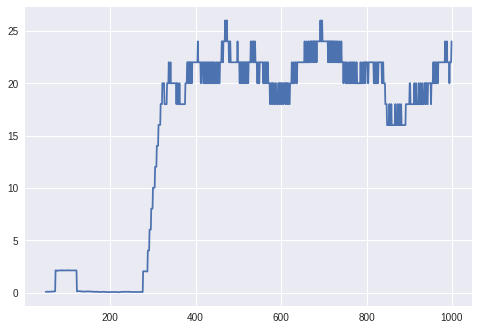

In [0]:
#@title Qlearning Agent.
class Qlearning(BaseAgent):
  """A Q-learning agent."""

  def _learning(self):
    loss, _ = trfl.qlearning(
        self._q_tm1, self._a_tm1, self._reward_t, self._discount_t, self._q_t)
    self._update_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# TF setup.
tf.reset_default_graph()
tf.set_random_seed(42)

# Train agent.
rewards = []
game = ChainWalk()
agent = Qlearning(7, 3, 0.2)

with tf.train.MonitoredSession() as sess:
  agent.setup(sess)
  obs, reward, discount = game.step(2)
  for _ in xrange(1000):
    action = agent.step(obs, reward, discount)
    obs, reward, discount = game.step(action)
    rewards.append(reward)

# Plot average reward per step.
smoothed_rewards = pd.rolling_mean(pd.DataFrame(rewards), window=50)
plt.plot(smoothed_rewards)